# Tutorial of Using qshap for Q-SHAP

## Install the Package `qshap`
`qshap` is available on PyPI. To install the package, run the following command in terminal:

In [ ]:
python -m pip install qshap

## Import Required Libraries
Before we start, we should import the `gazer` module in `qshap`.

In [2]:
from qshap import gazer

Then we import other important packages and modules for the usage of this tutorial.

In [3]:
import sklearn.ensemble
import numpy as np
import time as time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from sklearn.datasets import make_regression

## Make an Example Data
Let's start with a toy example with 1000 samples and 1000 features.

In [5]:
np.random.seed(0)
x, y, coefficients = make_regression(n_samples=1000, n_features=1000, coef=True, random_state=0)

## Example 1: Decision Tree from Scikit-learn
The initial run after import will be slower because `qshap` calls `Numba`, which uses a Just-in-Time (JIT) compiler that takes time to compile the functions.

### Construct the decision tree
We will use `DecisionTreeRegressor` from scikit-learn to train a decision tree on our simulated data.

In [6]:
# model fitting
# scikit learn decision tree example, the initial run after import will be slower since numba is comiling
max_depth = 2
tree_regressor = DecisionTreeRegressor(max_depth=max_depth)
tree_fit = tree_regressor.fit(x, y)

### Calculate feature-specific $R^2$
We instantiate the `gazer` class from `qshap` using the `tree_regressor` fitted in the previous stage. Then, we call the `rsq` method on this instance to calculate the Shapley $R^2$ using the `x` and `y` from our dataset.

In [7]:
gazer_rsq = gazer(tree_regressor)
rsq_res = gazer.rsq(gazer_rsq, x, y)

### Check with model $R^2$
In this section, we will check the model $R^2$ as well as the sum of Shapley $R^2$ calculated from `qshap` to verify the additivity property of Shapley values.

In [8]:
# Let's check the model R^2
ypred = tree_regressor.predict(x)
sst = np.sum((y - np.mean(y)) ** 2)
sse = np.sum((y - ypred) ** 2)
model_rsq = 1 - sse/sst

print("Shapley R^2 sum is: " + str(np.sum(rsq_res)))
print("Model R^2 is: " + str(model_rsq) + "\n")

Shapley R^2 sum is: 0.2759939277003993
Model R^2 is: 0.2759939277003993



## Example 2: Gradient Boosted Decision Trees from Scikit-learn
We will use the same dataset, but use Gradient Boosted Decision Trees (GBDT)s from `scikit-learn` instead. 

### Construct gradient boosted decision trees

In [9]:
max_depth = 2
n_estimators = 50
tree_regressor = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)
tree_fit = tree_regressor.fit(x, y)

### Calculate feature-specific $R^2$
Note that the usage is the same as using a decision tree as shown in the above example. We instantiate the `gazer` class from `qshap` using the `tree_regressor` fitted in the previous stage. Then, we call the `rsq` method on this instance to calculate the Shapley $R^2$ using the `x` and `y` from our dataset.

In [10]:
gazer_rsq = gazer(tree_regressor)
rsq_res = gazer.rsq(gazer_rsq, x, y)

100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 41.81it/s]


## Example 3: Tree Ensemble from XGBoost
We will demonstrate how to use `qshap` for XGBoost in this section, on the same dataset.

### Construct a tree ensemble using XGBoost

In [11]:
max_depth = 2
n_estimators = 50
tree_regressor = xgboost.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth)
tree_regressor.fit(x, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Calculate feature-specific $R^2$
Note that the usage is the same as using a decision tree as shown in the above example. We instantiate the `gazer` class from `qshap` using the `tree_regressor` fitted in the previous stage. Then, we call the `rsq` method on this instance to calculate the Shapley $R^2$ using the `x` and `y` from our dataset.

In [12]:
gazer_rsq = gazer(tree_regressor)
rsq_res = gazer.rsq(gazer_rsq, x, y)

100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.06it/s]


## Use Sampling Method for Data of Large Sample Size

When the sample size is very large, it would be very time-consuming to use all the samples to calculate Shapley $R^2$. Instead, users can use part of the samples by specifying the sampling number through `nsample`. 

In [13]:
gazer_rsq = gazer(tree_regressor)
rsq_res_frac = gazer.rsq(gazer_rsq, x, y, nsample=512)

100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.47it/s]


##  Extract Quadratic Loss for Each Sample
`qshap` calculates Shapley $R^2$ by aggregating decomposed quadratic losses over individual samples. The package allows to check the Shapley decomposition of quadratic losses of individual samples. 

### Output $R^2$ and quadratic loss
Setting the argument `loss_out` to `True` will simply output both $R^2$ and quadratic losses.

In [14]:
rsq_res2 = gazer.rsq(gazer_rsq, x, y, loss_out=True)
rsq_res2.rsq
rsq_res2.loss

100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 31.63it/s]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Output the quadratic loss only
If you are only intersted in the quadratic loss, its decomposition could be directly calculated using the `loss` funciton of the class `gazer`. 

In [15]:
loss_res = gazer.loss(gazer_rsq, x, y)

100%|███████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.75it/s]


### Calculate the quadratic loss for limited samples
If you are only interested in a small set of samples for their quadratic losses attached to different features, you don't need go through all samples. All you have to do is to add the original mean of y, in addition to the data of interest. This makes the calculation very fast, especially when the sample size is large. 

In [16]:
# loss decomposition for the first sample.
loss_sample1 = gazer.loss(gazer_rsq, x[0:1, :], y[0], y_mean_ori=np.mean(y))
# loss decomposition for the first 100 samples.
loss_multiple = gazer.loss(gazer_rsq, x[0:99], y[0:99], y_mean_ori=np.mean(y))

100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 168.52it/s]


## Visualization of Feature-Specific $R^2$
This section will demonstrate how to use the visualization module in `qshap`. 

### Import the module
First, we import the `vis` module from `qshap`.

In [18]:
from qshap import vis

### Quick plot
Simply call the `rsq` function in the `vis` class on the result from `gazer.rsq` to visualize.  
(`vis` is a general function that can work on numpy arrays).

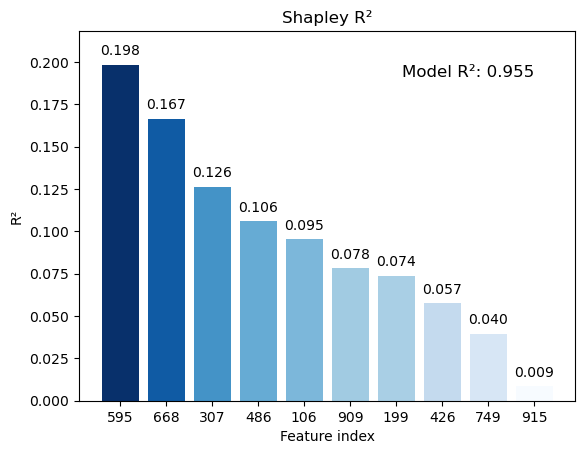

In [19]:
# default
vis.rsq(rsq_res)

### Different color schemes

You can change the color map of the histogram by changing `color_map_name`, taking arguments from `matplotlib`, with some examples [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html). In addition, you can focus on more influential by setting a cutoff of $R^2$ by changing the `cutoff` argument.

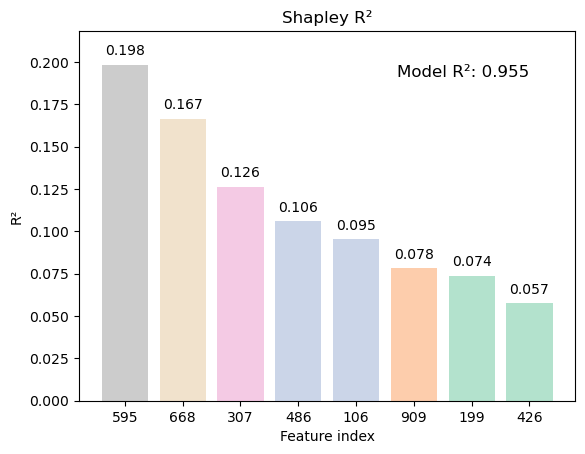

In [20]:
# change color 
vis.rsq(rsq_res, cutoff=0.05, color_map_name="Pastel2")

### More options
There are many other options for the visualization function. Below is an example that outputs a horizontal plot, hides "Model $R^2$" label, changes the number of features to show, and saves the plot in pdf format with a user-specified name. 

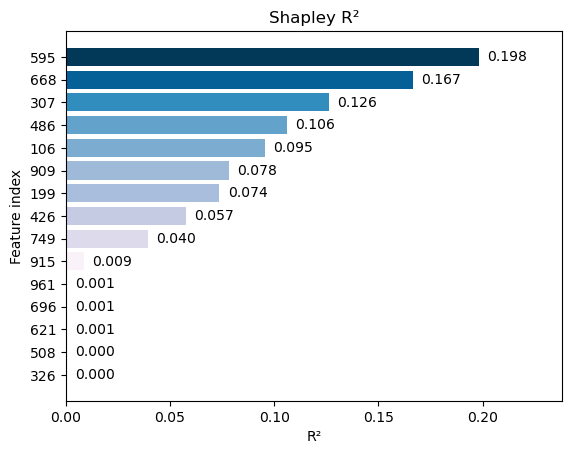

In [21]:
vis.rsq(rsq_res, color_map_name="PuBu", horizontal=True, model_rsq=False, max_feature=15, save_name="rsq_eg")

### Visualization of quadratic losses of individual samples
We can use the function `loss` to visualize the Shapley decomposition of individual quadratic losses.
The plot is interactive and you can explore the sample of interest by changing the value in the box next to "Sample Index". 

Output()

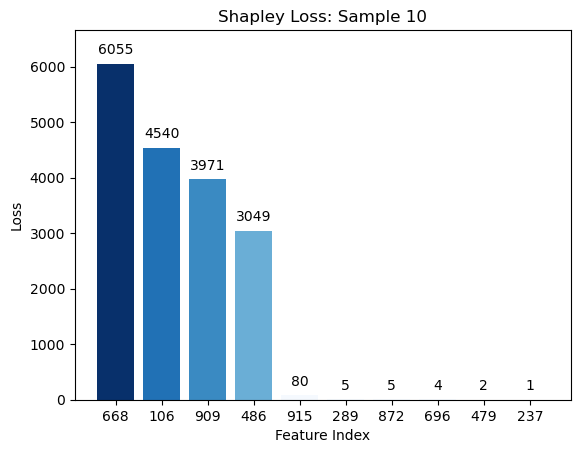

In [22]:
# Vidualize individual loss
# The interactive effect works with jupyter notebook
vis.loss(loss_res)

# Find a lovely plot for one sample and save it, say for the 10-th sample
vis.loss(loss_res, save_ind=10)

### Generalized correlation of individual features to the outcome
For each feature, its generalized correlation to the outcome is defined as the square root of its Shapley $R^2$. You can visualize it by simply calling `gcorr` on the output of `gazer.rsq`.

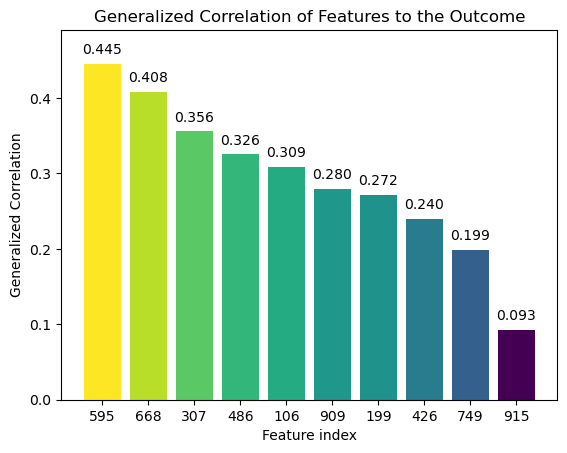

In [23]:
vis.gcorr(rsq_res, color_map_name="viridis")